# Proyek Klasifikasi Gambar: Animal Image Classification (cats, dogs, snakes)
- **Nama:** Arthurito Keintjem
- **Email:** keintjemarthurito@gmail.com
- **ID Dicoding:** arthuritokeintjem

## Import Semua Packages/Library yang Digunakan

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
from sklearn.model_selection import train_test_split
import shutil

## Data Preparation

### Data Loading

In [15]:
from pathlib import Path

orig_base = Path(r"C:\Users\arthur_k\Documents\Kuliah\Semester_6\DBS_Coding_Camp\Week 11 - 28 April\Animals")
split_base = Path(r"C:\Users\arthur_k\Documents\Kuliah\Semester_6\DBS_Coding_Camp\Week 11 - 28 April\Animals_split")
classes = ["cats", "dogs", "snakes"]

### Data Preprocessing

#### Split Dataset

In [16]:
for subset in ["train", "val", "test"]:
    for cls in classes:
        (split_base / subset / cls).mkdir(parents=True, exist_ok=True)

In [17]:
test_size = 0.10
val_size = 0.10 / (1 - test_size)  # relative to remaining after test

for cls in classes:
    files = list((orig_base / cls).glob("*.jpg"))
    if not files:
        print(f"No files found for class '{cls}'. Skipping...")
        continue
    train_val, test = train_test_split(files, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size, random_state=42)
    # Copy files
    for f in train:
        shutil.copy(f, split_base / "train" / cls / f.name)
    for f in val:
        shutil.copy(f, split_base / "val" / cls / f.name)
    for f in test:
        shutil.copy(f, split_base / "test" / cls / f.name)

#### ImageDataGenerators

In [26]:
# Augmentasi untuk training
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Hanya rescale untuk val/test
val_test_gen = ImageDataGenerator(rescale=1./255)

# Memuat data
target_size = (224, 224)
batch_size = 32

train_data = train_gen.flow_from_directory(
    split_base/"train", target_size=target_size,
    class_mode='categorical', batch_size=batch_size
)
val_data = val_test_gen.flow_from_directory(
    split_base/"val", target_size=target_size,
    class_mode='categorical', batch_size=batch_size
)
test_data = val_test_gen.flow_from_directory(
    split_base/"test", target_size=target_size,
    class_mode='categorical', batch_size=batch_size, shuffle=False
)

# Konfirmasi jumlah sampel
print(f"Train: {train_data.samples}, Val: {val_data.samples}, Test: {test_data.samples}")


Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Train: 2400, Val: 300, Test: 300


## Modelling

In [27]:
# Load base model
base_model = MobileNetV2(input_shape=(*target_size,3), include_top=False, weights='imagenet')
base_model.trainable = False

# Bangun model
d = train_data.num_classes
model = models.Sequential([
    layers.Conv2D(3, (1,1), activation='relu', input_shape=(*target_size,3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(d, activation='softmax')
])
model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,351 (9.24 MB)

 Trainable params: 164,367 (642.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Callbacks

In [29]:
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

#### Train Model

In [30]:
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4841 - loss: 1.1215 - val_accuracy: 0.9367 - val_loss: 0.2387 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8502 - loss: 0.4154 - val_accuracy: 0.9700 - val_loss: 0.1308 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 926ms/step - accuracy: 0.8872 - loss: 0.3003 - val_accuracy: 0.9733 - val_loss: 0.0958 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 941ms/step - accuracy: 0.8887 - loss: 0.2666 - val_accuracy: 0.9767 - val_loss: 0.0796 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 929ms/step - accuracy: 0.9297 - loss: 0.1905 - val_accuracy: 0.9733 - val_loss: 0.0728 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9225 - loss: 0.2002 - val_accuracy: 0.9733 - val_loss: 0.0739 - learning_rate: 1.0000e-04
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 74s 986ms/step - accuracy: 0

## Evaluasi dan Visualisasi

In [31]:
del model
model = tf.keras.models.load_model('best_model.keras')
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.9024 - loss: 0.2283
Test Accuracy: 94.67%


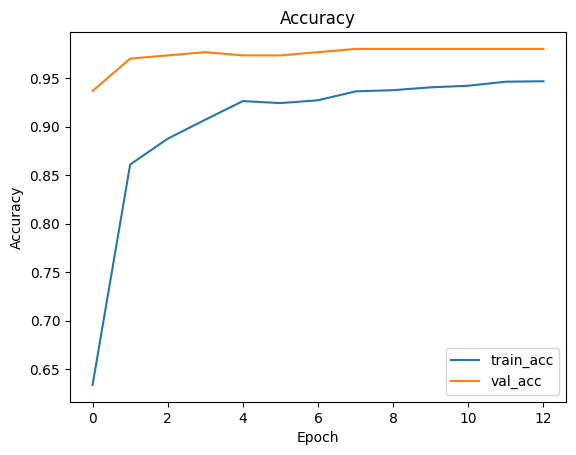

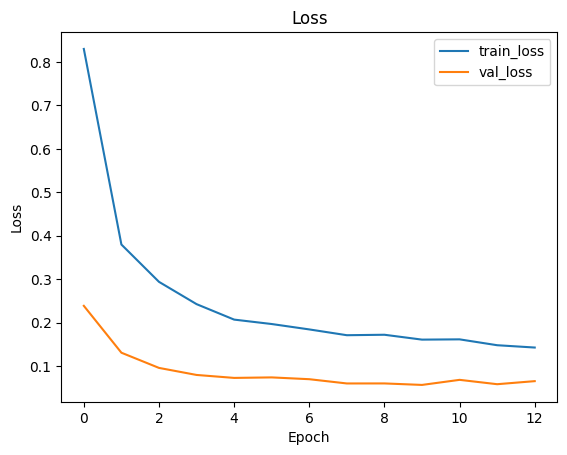

In [32]:
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Konversi Model

In [37]:
# SavedModel
model.export('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1489062802832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488954126608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488954123152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488958192720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488958190992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488954122960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488958180240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488958178512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488961354640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488961353488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1488958191568: TensorSpec(shape=(), dt

In [38]:
# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('./saved_model')
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f: f.write(tflite_model)

## Inference (Optional)

Test Accuracy: 94.67%


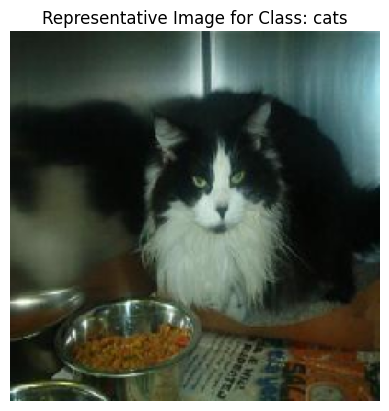

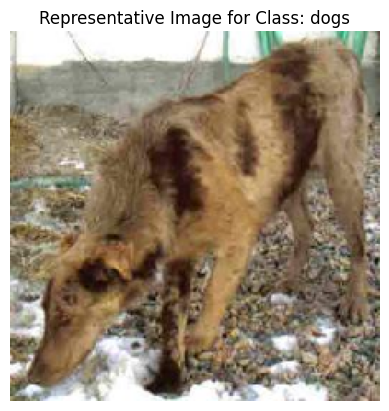

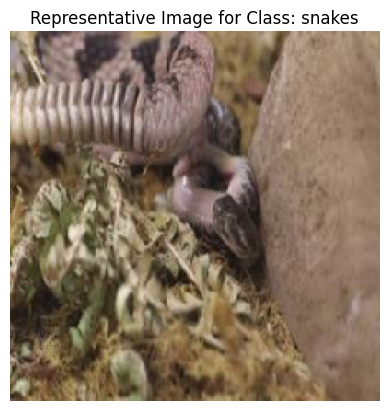

In [52]:
# Mendapatkan label kelas
class_labels = list(test_data.class_indices.keys())

# Initialize TensorFlow Lite interpreter
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Inference untuk semua gambar di test_data
correct = 0
total = 0
representative_images = {label: None for label in class_labels}

# Batasi jumlah batch untuk debugging (opsional)
max_batches = 10  # Set ke None untuk memproses semua batch

for batch_idx, (imgs, labels) in enumerate(test_data):
    if max_batches and batch_idx >= max_batches:
        break  # Hentikan setelah memproses sejumlah batch tertentu

    for i in range(len(imgs)):
        img = np.expand_dims(imgs[i], 0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_details[0]['index'])
        pred_class = np.argmax(pred)
        true_class = np.argmax(labels[i])

        # Hitung akurasi
        if pred_class == true_class:
            correct += 1
            # Simpan gambar representatif untuk kelas yang benar
            if representative_images[class_labels[true_class]] is None:
                representative_images[class_labels[true_class]] = imgs[i]

        total += 1

# Menampilkan akurasi
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Menampilkan gambar representatif untuk setiap kelas
for label, img in representative_images.items():
    if img is not None:
        plt.figure()
        plt.imshow(img)
        plt.title(f"Representative Image for Class: {label}")
        plt.axis('off')
        plt.show()